<center> <a href="https://dagshub.com"><img alt=\"DAGsHub\" width=500px src=https://raw.githubusercontent.com/DAGsHub/client/master/dagshub_github.png></a> </center>

# SavtaDepth Colab Environment

### ***This notebook is meant to be run on Google Colab***

This notebook is a tool to setup and run experiments for [SavtaDepth](https://dagshub.com/OperationSavta/SavtaDepth) on Google Colab, while maintaining a relatively clean environment and using version control to promote reproducibility. Following (and modifying where necessary) the cells below should let you git clone a project into colab, download the data, run it, and push it to https://DAGsHub.com which is a free platform for open source data science. 

SavtaDepth is an [Open Source Data Science](https://dagshub.com/blog/a-case-for-open-source-data-science/) project. We'd love to get help from the community, so if you'd like to contribute head over to the [project page](https://dagshub.com/OperationSavta/SavtaDepth) to get started.

# General Setup
**Before you start, make a copy of this notebook to your Google Drive**

In [1]:
%reload_ext autoreload
%autoreload 2

Clone Git Repo from DAGsHub. **Make sure to put in your username so that you clone your version of the project**.

In [ ]:
!git clone https://dagshub.com/{your_dagshub_user}/SavtaDepth.git
%cd /content/SavtaDepth/

### Install requirements for the project
You will be prompted to restart the runtime afterwards

In [ ]:
!pip install -r requirements.txt

In [ ]:
%cd /content/SavtaDepth/

### Pull DVC files from our remote

In [ ]:
!dvc pull -r origin src/data/processed/

#### ***Setup is done!***

---
# Testing the model (Optional)
If you want to dive ahead to modifying the model, skip to the next section


## Testing setup
Run these 3 cells before going further in the testing section. They are not necessary for the training section

In [28]:
import torch
import sys
from fastai.vision.all import *
import numpy as np

In [29]:
class ImageImageDataLoaders(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for Image to Image problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_func(cls, path, fnames, label_func, valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), ImageBlock(cls=PILImageBW)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

def get_y_fn(x):
    y = str(x.absolute()).replace('.jpg', '_depth.png')
    y = Path(y)

    return y


def create_data(data_path):
    fnames = get_files(data_path/'train', extensions='.jpg')
    data = ImageImageDataLoaders.from_label_func(data_path/'train',  bs=4, num_workers=0, fnames=fnames, label_func=get_y_fn)
    return data

In [ ]:
data = create_data(Path('src/data/processed'))
learner = unet_learner(data, resnet34, metrics=rmse, wd=1e-2, n_out=3, loss_func=MSELossFlat(), path='src/')
learner.load('model')

#### Your model is now loaded and ready!

## Making sure our model learned something


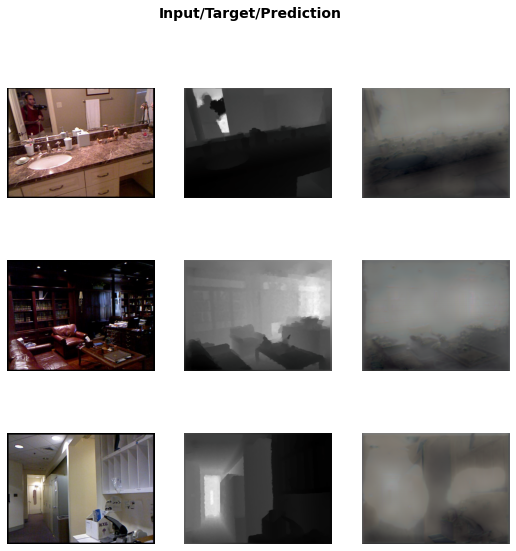

In [31]:
learner.show_results()

### Qualitative Results testing
We can upload an image and run the model on it

/content
/content/images


Saving WhatsApp Image 2020-10-12 at 18.57.25.jpeg to WhatsApp Image 2020-10-12 at 18.57.25.jpeg
/content


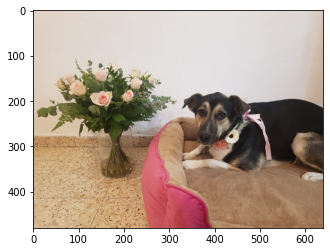

In [32]:
%cd /content/
%mkdir images
%cd images

from google.colab import files
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


# Upload Image
uploaded = files.upload()
original = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]]))

%cd /content/

original_shape = (original.shape[1],original.shape[0])
minified = original.resize((640,480))
minified_arr = np.array(minified)

plt.imshow(minified_arr)

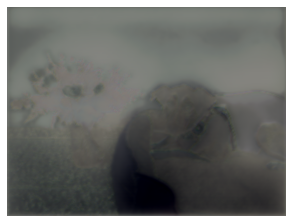

In [33]:
predicted_depth_map = (learner.predict(minified_arr))[0]
show_image(predicted_depth_map)

In [34]:
# Save our result
from torchvision import transforms
output = transforms.ToPILImage()(predicted_depth_map[:,:,:].type(torch.FloatTensor)).convert('L')
output = output.resize(original_shape)
output.save("images/" + list(uploaded.keys())[0].split('.')[0] + "_depth.jpg")

---
# Modifying the project!
If you've made it here, everything is set up. You have the code and data in the file viewer to the left. You can edit the files located in SavtaDepth/src/code/ as you like. You can see the YAML defining the project pipeline in dvc.yaml. If you change dependencies or outputs (for example, add an additional code file for the training stage), make sure you edit the pipeline to reflect this.

### Once you are done with your changes run the cell below to run the pipeline end-to-end
* You can run this multiple times if you've made a change and want to test it
* If you want to run only a specific stage you can change the `dvc repro` command to any other command you like.

▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽▽

In [ ]:
!dvc repro

**---Or---**<br/>
Run a specific stage and commit its results to dvc

In [ ]:
# Using %run magic lets you see the progress bar properly!
# If you're not sure what command to run, look in the dvc.yaml file
%run -i {script.py} {qargs}

In [ ]:
!dvc status

In [ ]:
!dvc commit {stage or file name}



---
### Clean up code – use if you got a CUDA out of memory error.


In [23]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

---
# Commiting Your Work and Pushing Back to DAGsHub



In [ ]:
%cd /content/SavtaDepth/

In [ ]:
!git status

In [6]:
# Add the files you want to commit
!git add {your files here}

Run the following 2 cells without modifications. They will prompt you for a commit message, and for credentials to push back to DAGsHub

**Commiting**

In [ ]:
import os
os.environ['EMAIL'] = input('Enter your email: ')
os.environ['NAME'] = input('Enter your user name: ')
os.environ['COMMIT_MESSAGE'] = input('Enter the commit message for you commit: ')
!git config --global user.email "${EMAIL}"
!git config --global user.name "${NAME}"
!git commit -m "${COMMIT_MESSAGE}"
os.environ['COMMIT_MESSAGE'] = os.environ['NAME'] = os.environ['EMAIL'] = ""

**Pushing to DAGsHub**

In [ ]:
# If this stage fails, make sure to remove outputs as it will show your password to whoever it is shared with.
from getpass import getpass
import os

os.environ['USER'] = input('Enter the username of your DAGsHub account: ')
os.environ['PASSWORD'] = getpass('Enter the password of your DAGsHub account: ')
os.environ['REPO_URL'] = input('Enter the url of your DAGsHub project: ').split('https://')[-1]
os.environ['DAGSHUB_AUTH'] = os.environ['USER'] + ':' + os.environ['PASSWORD']

!git push https://$DAGSHUB_AUTH@$REPO_URL.git

os.environ['PASSWORD'] = os.environ['DAGSHUB_AUTH'] = ""

***NOTE: ALWAYS RUN THIS CELL AFTER THE PREVIOUS***, it will delete your DAGsHub password in case you share this notebook with someone

In [13]:
os.environ['PASSWORD'] = os.environ['DAGSHUB_AUTH'] = ""

## Push data back to your DVC Remote
For this step you must first create a DVC remote on some cloud provider. We recommend Google Cloud Storage. If you're not sure how to set up a DVC remote, [follow these instructions](https://dagshub.com/docs/getting-started/set-up-remote-storage-for-data-and-models/#create-a-storage-bucket) (you only need to go through creating a storage bucket and adding permissions).

Add your storage bucket to DVC (replace {bucket-name} with the bucket name you chose)

In [ ]:
!dvc remote modify origin url https://dagshub.com/{your_dagshub_user}/SavtaDepth.dvc"

In [ ]:
!dvc remote modify origin --local auth basic
!dvc remote modify origin --local user {your user name}
!dvc remote modify origin --local ask_password true
!dvc push -r origin

# That's it, you can now create a PR on DAGsHub.